<h1>Convolutional Neural Network</h1>

<h2>Import Dependencies</h2>

In [1]:
import numpy as np
import h5py 
import matplotlib.pyplot as plt

In [2]:
np.random.seed(1)

<h2>Zero-Padding</h2>

In [3]:
def zero_pad(X, pad):
    '''
    using zeros to pad input image
    
    Args:
    X -- input image. shape: (m, n_H, n_W, n_C)
    pad -- padding size
    
    Returns:
    X_pad -- padded image. shape: (m, n_H + 2 * pad, n_W + 2 * pad, n_C)
    '''
    
    X_pad = np.pad(X, ((0,0), (pad,pad), (pad,pad), (0,0)), mode='constant')
    return X_pad

x.shape =
 (4, 3, 3, 2)
x_pad.shape =
 (4, 9, 9, 2)
x[1,1] =
 [[ 0.90085595 -0.68372786]
 [-0.12289023 -0.93576943]
 [-0.26788808  0.53035547]]
x_pad[1,1] =
 [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


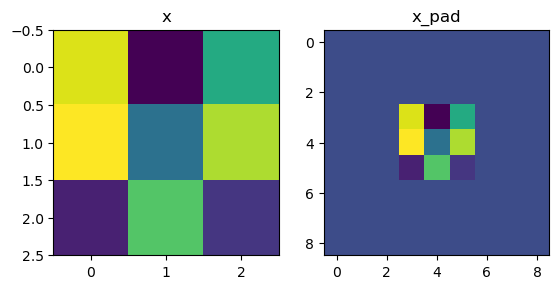

In [4]:
# test

np.random.seed(1)
x = np.random.randn(4, 3, 3, 2)
x_pad = zero_pad(x, 3)
print ("x.shape =\n", x.shape)
print ("x_pad.shape =\n", x_pad.shape)
print ("x[1,1] =\n", x[1, 1])
print ("x_pad[1,1] =\n", x_pad[1, 1])

fig, axarr = plt.subplots(1, 2)
axarr[0].set_title('x')
axarr[0].imshow(x[0, :, :, 0])
axarr[1].set_title('x_pad')
axarr[1].imshow(x_pad[0, :, :, 0])

<h2>Single Step Convolution</h2>

In [5]:
def conv_single_step(a_slice_prev, W, b):
    '''
    Apple one filter to image
    
    Args:
    a_slice_prev -- input data. shape: (f, f, n_C_prev)
    W -- weights. shape: (f, f, n_C_prev)
    b -- bias. shape: (1, 1, 1)
    
    Returns:
    Z -- convolvedata
    '''
    
    Z = np.multiply(a_slice_prev, W)
    s = np.sum(Z)
    Z = s + float(b)
    
    return Z    

In [6]:
# test
np.random.seed(1)
a_slice_prev = np.random.randn(4, 4, 3)
W = np.random.randn(4, 4, 3)
b = np.random.randn(1, 1, 1)

Z = conv_single_step(a_slice_prev, W, b)
print("Z =", Z)

Z = -6.999089450680221


<h2>Convolution Forward Propagation</h2>

In [7]:
def conv_forward(A_prev, W, b, hyperparameters):
    '''
    Convolutional forward propgation
    
    Args:
    A_prev -- the previous input. shape: (m, n_H_prev, n_W_prev, n_C_prev)
    W - weights. shape: (f, f, n_C_prev, n_C)
    b -- bias. (1, 1, 1, n_C)
    hyperparameters -- dictionary contains 'stride' and 'pad'
    
    Returns:
    Z -- convolvo output. shape: (m, n_H, n_W, n_C)
    cache -- intermediate variables for convolve backprop
    '''
    
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    (f, f, n_C_prev, n_C) = W.shape
    stride = hyperparameters['stride']
    pad = hyperparameters['pad']
    
    n_H = int((n_H_prev - f + 2 * pad) / stride) + 1
    n_W = int((n_W_prev - f + 2 * pad) / stride) + 1
    n_C = n_C
    Z = np.zeros((m, n_H, n_W, n_C))
    
    A_prev_pad = zero_pad(A_prev, pad)
    for i in range(m):
        a_prev_pad = A_prev_pad[i]
        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):
                    vert_start = stride * h
                    vert_end = vert_start + f
                    horiz_start = stride * w
                    horiz_end = horiz_start + f
                    a_slice_prev = a_prev_pad[vert_start:vert_end,horiz_start:horiz_end,:]
                    Z[i,h,w,c] = conv_single_step(a_slice_prev, W[:,:,:,c], b[:,:,:,c])
                    
    cache = (A_prev, W, b, hyperparameters)
    
    return Z, cache

In [8]:
# test

np.random.seed(1)
A_prev = np.random.randn(2, 5, 7, 4)
W = np.random.randn(3, 3, 4, 8)
b = np.random.randn(1, 1, 1, 8)
hparameters = {"pad" : 1,
               "stride": 2}

Z, cache_conv = conv_forward(A_prev, W, b, hparameters)
z_mean = np.mean(Z)
z_0_2_1 = Z[0, 2, 1]
cache_0_1_2_3 = cache_conv[0][1][2][3]
print(f'shape of Z: {Z.shape}')
print("Z's mean =\n", z_mean)
print("Z[0,2,1] =\n", z_0_2_1)
print("cache_conv[0][1][2][3] =\n", cache_0_1_2_3)

shape of Z: (2, 3, 4, 8)
Z's mean =
 0.5511276474566768
Z[0,2,1] =
 [-2.17796037  8.07171329 -0.5772704   3.36286738  4.48113645 -2.89198428
 10.99288867  3.03171932]
cache_conv[0][1][2][3] =
 [-1.1191154   1.9560789  -0.3264995  -1.34267579]


<h2>Pooling</h2>

<h3>Forward Pooling</h3>

In [9]:
def pool_forward(A_prev, hyperparameters, mode='max'):
    '''
    forward prop pooling
    
    Args:
    A_prev -- previous layer input
    hyperparameter -- padding, stride and pooling size
    mode -- pooling type, accept: max or avg
    '''
    
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    f = hyperparameters['f']
    stride = hyperparameters['stride']
    n_H = int(1 + (n_H_prev - f) / stride)
    n_W = int(1 + (n_W_prev - f) / stride)
    n_C = n_C_prev
    
    A = np.zeros((m, n_H, n_W, n_C))
   
    for i in range(m):
        a_prev_slice = A_prev[i]
        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):
                    vert_start = h * stride
                    vert_end = vert_start + f
                    horiz_start = w * stride
                    horiz_end = horiz_start + f
                    if mode == 'max':
                        A[i,h,w,c] = np.max(a_prev_slice[vert_start:vert_end,horiz_start:horiz_end,c])
                    elif mode == 'avg':
                        A[i,h,w,c] = np.mean(a_prev_slice[vert_start:vert_end,horiz_start:horiz_end,c])
                        
    cache = (A_prev, hyperparameters)
    
    return A, cache

In [10]:
# Case 1: stride of 1
np.random.seed(1)
A_prev = np.random.randn(2, 5, 5, 3)
hparameters = {"stride" : 1, "f": 3}

A, cache = pool_forward(A_prev, hparameters, mode = "max")
print("mode = max")
print("A.shape = " + str(A.shape))
print("A[1, 1] =\n", A[1, 1])
A, cache = pool_forward(A_prev, hparameters, mode = "avg")
print("mode = average")
print("A.shape = " + str(A.shape))
print("A[1, 1] =\n", A[1, 1])

mode = max
A.shape = (2, 3, 3, 3)
A[1, 1] =
 [[1.96710175 0.84616065 1.27375593]
 [1.96710175 0.84616065 1.23616403]
 [1.62765075 1.12141771 1.2245077 ]]
mode = average
A.shape = (2, 3, 3, 3)
A[1, 1] =
 [[ 0.44497696 -0.00261695 -0.31040307]
 [ 0.50811474 -0.23493734 -0.23961183]
 [ 0.11872677  0.17255229 -0.22112197]]


In [11]:
# Case 2: stride of 2
np.random.seed(1)
A_prev = np.random.randn(2, 5, 5, 3)
hparameters = {"stride" : 2, "f": 3}

A, cache = pool_forward(A_prev, hparameters)
print("mode = max")
print("A.shape = " + str(A.shape))
print("A[0] =\n", A[0])
print()

A, cache = pool_forward(A_prev, hparameters, mode = "avg")
print("mode = average")
print("A.shape = " + str(A.shape))
print("A[1] =\n", A[1])

mode = max
A.shape = (2, 2, 2, 3)
A[0] =
 [[[1.74481176 0.90159072 1.65980218]
  [1.74481176 1.6924546  1.65980218]]

 [[1.13162939 1.51981682 2.18557541]
  [1.13162939 1.6924546  2.18557541]]]

mode = average
A.shape = (2, 2, 2, 3)
A[1] =
 [[[-0.17313416  0.32377198 -0.34317572]
  [ 0.02030094  0.14141479 -0.01231585]]

 [[ 0.42944926  0.08446996 -0.27290905]
  [ 0.15077452  0.28911175  0.00123239]]]


<h2>Convolution Backward Propagation</h2>

In [31]:
def conv_backward(dZ, cache):
    '''
    perform convolution backward propgation
    
    Args:
    dZ -- dloss to dZ. shape: (m, n_H, n_W, n_C)
    cache -- intermediate variables for backward propagation.
    
    Returns:
    dA_prev -- gradient of input 
    dW -- gradient of filter weights
    db -- gradient of filter bias
    '''
    
    (A_prev, W, b, hyperparameters) = cache
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    (f, f, n_C_prev, n_C) = W.shape
    
    stride = hyperparameters['stride']
    pad = hyperparameters['pad']
    
    (m, n_H, n_W, n_C) = dZ.shape
    
    dA_prev = np.zeros(A_prev.shape)
    dW = np.zeros(W.shape)
    db = np.zeros(b.shape)
    
    A_prev_pad = zero_pad(A_prev, pad)
    dA_prev_pad = zero_pad(dA_prev, pad)
    
    for i in range(m):
        a_prev_pad = A_prev_pad[i]
        da_prev_pad = dA_prev_pad[i]
        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):
                    vert_start = stride * h
                    vert_end = vert_start + f
                    horiz_start = stride * w
                    horiz_end = horiz_start + f
                    a_slice = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :]
                    da_prev_pad[vert_start:vert_end,horiz_start:horiz_end,:] += W[:,:,:,c] * dZ[i,h,w,c]
                    dW[:,:,:,c] += a_slice * dZ[i,h,w,c]
                    db[:,:,:,c] += dZ[i,h,w,c]
                    
        dA_prev[i] = da_prev_pad[pad:-pad,pad:-pad,:]
                    
        
    return dA_prev, dW, db

In [32]:
np.random.seed(1)
A_prev = np.random.randn(10, 4, 4, 3)
W = np.random.randn(2, 2, 3, 8)
b = np.random.randn(1, 1, 1, 8)
hparameters = {"pad" : 2,
               "stride": 2}
Z, cache_conv = conv_forward(A_prev, W, b, hparameters)

# Test conv_backward
dA, dW, db = conv_backward(Z, cache_conv)

print("dA_mean =", np.mean(dA))
print("dW_mean =", np.mean(dW))
print("db_mean =", np.mean(db))

dA_mean = 1.4524377775388075
dW_mean = 1.7269914583139097
db_mean = 7.839232564616838


<h2>Pooling Backward Propagation</h2>

<h3>Max Pooling Backward Propagation</h3>

In [14]:
def create_mask_from_window(x):
    '''
    create mask for max pooling
    
    Args:
    x -- input
    
    Returns:
    masked_x -- input after masked
    '''
    masked_x = (x == np.max(x))
    return masked_x

In [15]:
# test

np.random.seed(1)
x = np.random.randn(2, 3)
mask = create_mask_from_window(x)
print('x = ', x)
print("mask = ", mask)

x = np.array([[-1, 2, 3],
              [2, -3, 2],
              [1, 5, -2]])

y = np.array([[False, False, False],
     [False, False, False],
     [False, True, False]])
mask = create_mask_from_window(x)


x =  [[ 1.62434536 -0.61175641 -0.52817175]
 [-1.07296862  0.86540763 -2.3015387 ]]
mask =  [[ True False False]
 [False False False]]


<h3>Average Pooling Backward Propagation</h3>

In [16]:
def distribute_value(dz, shape):
    '''
    distributes the input value to the matrix
    
    Args:
    dz -- input
    shape - matrix
    
    Returns:
    a -- distributed value matrix
    '''
    
    a = np.full(shape, dz / (shape[0] * shape[1]))
    return a

In [17]:
# test

a = distribute_value(2, (2, 2))
print('distributed value =', a)

distributed value = [[0.5 0.5]
 [0.5 0.5]]


In [18]:
def pool_backward(dA, cache, mode = 'max'):
    '''
    perform pooling backward propagation
    
    Args:
    dA -- gradient of pooling output
    cache -- intermediate variables for computing
    mode -- pooling type, accpet 'max' or 'avg'
    
    Returns:
    dA_prev -- gradient of the output from previous layer
    '''
    
    (A_prev, hyperparameters) = cache
    stride = hyperparameters['stride']
    f = hyperparameters['f']
    m, n_H_prev, n_W_prev, n_C_prev = A_prev.shape
    m, n_H, n_W, n_C = dA.shape
    
    dA_prev = np.zeros(A_prev.shape)
    
    for i in range(m):
        a_prev = A_prev[i]
        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):
                    vert_start = stride * h
                    vert_end = vert_start + f
                    horiz_start = stride * w
                    horiz_end = horiz_start + f
                    if mode == 'max':
                        mask = a_prev[vert_start:vert_end,horiz_start:horiz_end,c] = create_mask_from_window(a_prev[vert_start:vert_end,horiz_start:horiz_end,c])
                        dA_prev[i,vert_start:vert_end,horiz_start:horiz_end,c] += np.multiply(dA[i,h,w,c], mask)
                    elif mode == 'avg':
                        dA_prev[i,vert_start:vert_end,horiz_start:horiz_end,c] += distribute_value(dA[i,h,w,c], (f,f))
    
    return dA_prev

In [20]:
# test

np.random.seed(1)
A_prev = np.random.randn(5, 5, 3, 2)
hparameters = {"stride" : 1, "f": 2}
A, cache = pool_forward(A_prev, hparameters)
print(A.shape)
print(cache[0].shape)
dA = np.random.randn(5, 4, 2, 2)

dA_prev1 = pool_backward(dA, cache, mode = "max")
print("mode = max")
print('mean of dA = ', np.mean(dA))
print('dA_prev1[1,1] = ', dA_prev1[1, 1])  
print()
dA_prev2 = pool_backward(dA, cache, mode = "avg")
print("mode = average")
print('mean of dA = ', np.mean(dA))
print('dA_prev2[1,1] = ', dA_prev2[1, 1]) 

(5, 4, 2, 2)
(5, 5, 3, 2)
mode = max
mean of dA =  0.14571390272918056
dA_prev1[1,1] =  [[ 0.          0.        ]
 [ 5.05844394 -1.68282702]
 [ 0.          0.        ]]

mode = average
mean of dA =  0.14571390272918056
dA_prev2[1,1] =  [[ 0.08485462  0.2787552 ]
 [ 1.26461098 -0.25749373]
 [ 1.17975636 -0.53624893]]
